In [1]:
import sys
import os
import time
import shutil
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms as T

from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from functions import torch2np_u8
import plot
from plot import post_epoch_plot
from models import SpecialFuseNetModel
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from train import FuseNetTrainer

np.set_printoptions(threshold=sys.maxsize)
# %matplotlib notebook

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
CWD             = os.getcwd()
DATASET_DIR     = os.path.join(CWD,'data/nyuv2_overfit')
print(DATASET_DIR)

/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_overfit


In [4]:
BATCH_SIZE  = 4
NUM_WORKERS = 4
TRAIN_TEST_RATIO = 0.5
IMAGE_SIZE = (64,64)

In [5]:
dl_train, dl_test = rgbd_gradients_dataloader(device=device,
                                              root=DATASET_DIR,use_transforms=True, overfit_mode=True,
                                              batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train_test_ratio=TRAIN_TEST_RATIO,
                                              image_size=IMAGE_SIZE)

[I (rgbd_gradients_dataloader)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_overfit
                                - device=cpu
                                - batch_size=4
                                - num_workers=4
                                - train_test_ratio=0.5
                                - image_size=(64, 64)
                                - use_transforms=True
                                - overfit_mode=True
                                - seed=42
                                - goto_pixel=True

[I (rgbd_gradients_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_overfit
                             - image_size=(64, 64)
                             - use_transforms=True
                             - overfit_mode=True
                             - goto_pixel=True

[I] - |self|=1
[D (rgbd_gradients_dataloader)] - |Dataset|=1


## Check train set & test set equals:

In [6]:
train_sample_batch = next(iter(dl_train))
test_sample_batch  = next(iter(dl_test))

rgb_train_eq_test   = not np.any(train_sample_batch['rgb'].numpy()-test_sample_batch['rgb'].numpy())
depth_train_eq_test = not np.any(train_sample_batch['depth'].numpy()-test_sample_batch['depth'].numpy())
x_train_eq_test     = not np.any(train_sample_batch['x'].numpy()-test_sample_batch['x'].numpy())
y_train_eq_test     = not np.any(train_sample_batch['y'].numpy()-test_sample_batch['y'].numpy())

print(f'RGB(train) == RGB(test) : {rgb_train_eq_test}')
print(f'DEPTH(train) == DEPTH(test) : {depth_train_eq_test}')
print(f'X(train) == X(test) : {x_train_eq_test}')
print(f'Y(train) == Y(test) : {y_train_eq_test}')

RGB(train) == RGB(test) : True
DEPTH(train) == DEPTH(test) : True
X(train) == X(test) : True
Y(train) == Y(test) : True


In [7]:
rgb_size   = tuple(train_sample_batch['rgb'].shape[1:])
depth_size = tuple(train_sample_batch['depth'].shape[1:])
grads_size = tuple(train_sample_batch['x'].shape[1:])

In [8]:
fusenetmodel = SpecialFuseNetModel(rgb_size=rgb_size, depth_size=depth_size, grads_size=grads_size,
                                   device=device, dropout_p=0)

[I] - device=cpu
    - seed=42
    - dropout_p=0
    - optimizer=None
    - scheduler=None

[I] - Init SpecialFuseNet
    - warm start=True
    - BN momentum=0.1
    - dropout_p=0

[I] - Check Features ... Done.
[I] - Initialize Net.
    - Init type=xavier
    - Init gain=0.02

[I] - default optimizer set: SGD(lr=0.001,momentum=0.9,weight_decay=0.0005)
[I] - default scheduler set: StepSR(step_size=1000,gamma=0.1)


In [9]:
train_sample_batch1 = next(iter(dl_train))
train_sample_batch2 = next(iter(dl_train))
print(f"Consecutive RGB        train mini-batchs equals: {not np.any((train_sample_batch1['rgb']-train_sample_batch2['rgb']).numpy())}")
print(f"Consecutive D          train mini-batchs equals: {not np.any((train_sample_batch1['depth']-train_sample_batch2['depth']).numpy())}")
print(f"Consecutive X          train mini-batchs equals: {not np.any((train_sample_batch1['x']-train_sample_batch2['x']).numpy())}")
print(f"Consecutive Y          train mini-batchs equals: {not np.any((train_sample_batch1['y']-train_sample_batch2['y']).numpy())}")
xy1 = fusenetmodel(train_sample_batch1['rgb'],train_sample_batch1['depth']).detach()
xy2 = fusenetmodel(train_sample_batch2['rgb'],train_sample_batch2['depth']).detach()
print(f"Outputs on consecutive train mini-batchs equals: {not np.any((xy1-xy2).numpy())}")

Consecutive RGB        train mini-batchs equals: True
Consecutive D          train mini-batchs equals: True
Consecutive X          train mini-batchs equals: True
Consecutive Y          train mini-batchs equals: True
Outputs on consecutive train mini-batchs equals: True


In [10]:
test_sample_batch1 = next(iter(dl_test))
test_sample_batch2 = next(iter(dl_test))
print(f"Consecutive RGB        test mini-batchs equals: {not np.any((test_sample_batch1['rgb']-test_sample_batch2['rgb']).numpy())}")
print(f"Consecutive D          test mini-batchs equals: {not np.any((test_sample_batch1['depth']-test_sample_batch2['depth']).numpy())}")
print(f"Consecutive X          test mini-batchs equals: {not np.any((test_sample_batch1['x']-test_sample_batch2['x']).numpy())}")
print(f"Consecutive Y          test mini-batchs equals: {not np.any((test_sample_batch1['y']-test_sample_batch2['y']).numpy())}")
xy1 = fusenetmodel(test_sample_batch1['rgb'],test_sample_batch1['depth']).detach()
xy2 = fusenetmodel(test_sample_batch2['rgb'],test_sample_batch2['depth']).detach()
print(f"Outputs on consecutive test mini-batchs equals: {not np.any((xy1-xy2).numpy())}")

Consecutive RGB        test mini-batchs equals: True
Consecutive D          test mini-batchs equals: True
Consecutive X          test mini-batchs equals: True
Consecutive Y          test mini-batchs equals: True
Outputs on consecutive test mini-batchs equals: True


In [11]:
train_sample_batch = next(iter(dl_train))
test_sample_batch  = next(iter(dl_test))
print(f"Inputs RGB   train & test mini-batchs equals: {not np.any((train_sample_batch['rgb']-test_sample_batch['rgb']).numpy())}")
print(f"Inputs DEPTH train & test mini-batchs equals: {not np.any((train_sample_batch['depth']-test_sample_batch['depth']).numpy())}")
print(f"Inputs X     train & test mini-batchs equals: {not np.any((train_sample_batch['x']-test_sample_batch['x']).numpy())}")
print(f"Inputs Y     train & test mini-batchs equals: {not np.any((train_sample_batch['y']-test_sample_batch['y']).numpy())}")

xy1 = fusenetmodel(train_sample_batch['rgb'],train_sample_batch['depth']).detach()
xy2 = fusenetmodel(test_sample_batch['rgb'],test_sample_batch['depth']).detach()
print(f"Outputs on   train & test mini-batchs equals: {not np.any((xy1-xy2).numpy())}")

Inputs RGB   train & test mini-batchs equals: True
Inputs DEPTH train & test mini-batchs equals: True
Inputs X     train & test mini-batchs equals: True
Inputs Y     train & test mini-batchs equals: True
Outputs on   train & test mini-batchs equals: True


In [12]:
checkpoint_file = 'checkpoints/special_fusenet_overfit'
final_checkpoint_file = checkpoint_file + '_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [13]:
trainer = FuseNetTrainer(model=fusenetmodel, device=device, num_epochs=50)

[I (FuseNetTrainer)] - model=<models.SpecialFuseNetModel object at 0x7fa8bc7aff10>
                     - num_epochs=50
                     - device=cpu
                      - seed=42



--- EPOCH 1/50 ---
test_batch (Avg. Loss 0.065: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
False


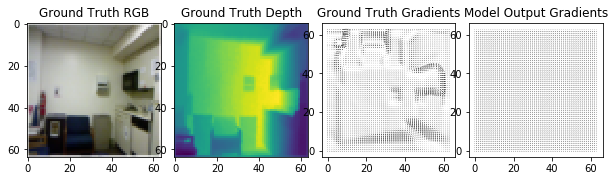

train_batch:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [14]:
fit_res = trainer.fit(dl_train=dl_train, dl_test=dl_test, print_every=10, post_epoch_fn=post_epoch_plot, 
                      checkpoints=checkpoint_file)

In [ ]:
fig,ax = plt.subplots()
ax.plot(fit_res.train_loss, label='train_loss')
ax.plot(fit_res.test_loss, label='test_loss')
plt.legend()
plt.show()